In [1]:
import numpy as np
from matplotlib import pyplot as plt
import uproot
import pandas as pd

import os
import xgboost as xgb

In [2]:
directory=os.getcwd()

In [3]:
#directory

In [4]:
algo_name=[]
algo_name.append('T23')
algo_name.append('SDH')
algo_name.append('SDH0')
algo_name.append('SDH10')
algo_name.append('SDH20')
algo_name.append('TDH')
algo_name.append('TDH0')
algo_name.append('TDH10')
algo_name.append('TDH20')

algo_e={}
algo_p={}
algo={}

In [5]:
%%time
gen_e=pd.read_csv('./electron/gen_clean.csv')
algo_e[0]=pd.read_csv('./electron/T23.csv')
algo_e[1]=pd.read_csv('./electron/SDH.csv')
algo_e[2]=pd.read_csv('./electron/SDH0.csv')
algo_e[3]=pd.read_csv('./electron/SDH10.csv')
algo_e[4]=pd.read_csv('./electron/SDH20.csv')
algo_e[5]=pd.read_csv('./electron/TDH.csv')
algo_e[6]=pd.read_csv('./electron/TDH0.csv')
algo_e[7]=pd.read_csv('./electron/TDH10.csv')
algo_e[8]=pd.read_csv('./electron/TDH20.csv')
gen_p=pd.read_csv('./pion/gen_clean.csv')
algo_p[0]=pd.read_csv('./pion/T23.csv')
algo_p[1]=pd.read_csv('./pion/SDH.csv')
algo_p[2]=pd.read_csv('./pion/SDH0.csv')
algo_p[3]=pd.read_csv('./pion/SDH10.csv')
algo_p[4]=pd.read_csv('./pion/SDH20.csv')
algo_p[5]=pd.read_csv('./pion/TDH.csv')
algo_p[6]=pd.read_csv('./pion/TDH0.csv')
algo_p[7]=pd.read_csv('./pion/TDH10.csv')
algo_p[8]=pd.read_csv('./pion/TDH20.csv')

Wall time: 38.4 s


In [6]:
for i in range(len(algo_name)):
    algo[i]=pd.concat([algo_e[i],algo_p[i]], sort=False)

In [7]:
#algo[0].info()

In [8]:
%%time
#cut
ptcut=10
etamin=1.6
etamax=2.9
algo_cut={}
for i in algo:
    sel=algo[i]['genpart_pt']>ptcut
    algo_cut[i]=algo[i][sel]
    sel=np.abs(algo_cut[i]['genpart_exeta'])>etamin
    algo_cut[i]=algo_cut[i][sel]
    sel=np.abs(algo_cut[i]['genpart_exeta'])<etamax
    algo_cut[i]=algo_cut[i][sel]
    algo_cut[i].dropna(inplace=True)
    algo_cut[i]['genpart_pid'].replace([-11,11],0, inplace=True)
    algo_cut[i]['genpart_pid'].replace([-211,211],1, inplace=True)

Wall time: 7.68 s


In [9]:
from sklearn.model_selection import train_test_split
columns=['cl3d_eta','cl3d_showerlength',
       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer',
       'cl3d_seetot', 'cl3d_spptot', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmean','cl3d_pt']


X_train={}
X_test={}
y_train={}
y_test={}

for i in algo:
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(algo_cut[i][columns], algo_cut[i]['genpart_pid'], test_size=0.2)

In [10]:
X_pt={}
for i in algo:
    X_pt[i]=X_test[i]['cl3d_pt']
    X_test[i]=X_test[i].drop(columns='cl3d_pt')
    X_train[i]=X_train[i].drop(columns='cl3d_pt')
    
columns.remove('cl3d_pt')


In [11]:
train={}
test={}

for i in algo:
    train[i] = xgb.DMatrix(data=X_train[i],label=y_train[i], feature_names=columns)
    test[i] = xgb.DMatrix(data=X_test[i],label=y_test[i],feature_names=columns)

C:\ProgramData\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [12]:
param = {}

# Booster parameters
param['nthread']          = 30  # limit number of threads
param['eta']              = 0.1 # learning rate
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on
param['silent'] = True

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

In [13]:
%%time
booster={}
for i in algo:
    booster[i] = xgb.train(param,train[i],num_boost_round=num_trees);

Wall time: 8min 41s


In [14]:
for i in algo:
    print(algo_name[i],'\t',booster[i].eval(test[i]))

T23 	 [0]	eval-error:0.016972	eval-logloss:0.059323	eval-rmse:0.119924
SDH 	 [0]	eval-error:0.010673	eval-logloss:0.039491	eval-rmse:0.094450
SDH0 	 [0]	eval-error:0.010289	eval-logloss:0.040759	eval-rmse:0.094732
SDH10 	 [0]	eval-error:0.010282	eval-logloss:0.038725	eval-rmse:0.093587
SDH20 	 [0]	eval-error:0.009609	eval-logloss:0.037019	eval-rmse:0.090980
TDH 	 [0]	eval-error:0.010091	eval-logloss:0.037718	eval-rmse:0.092536
TDH0 	 [0]	eval-error:0.010404	eval-logloss:0.038910	eval-rmse:0.094780
TDH10 	 [0]	eval-error:0.009870	eval-logloss:0.037088	eval-rmse:0.091954
TDH20 	 [0]	eval-error:0.009400	eval-logloss:0.035797	eval-rmse:0.089885


In [15]:
predictions={}
for i in algo:
    predictions[i]=booster[i].predict(test[i])

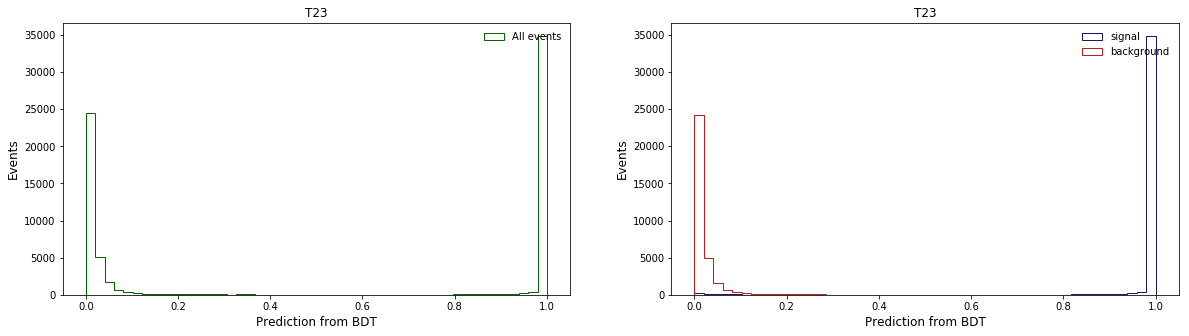

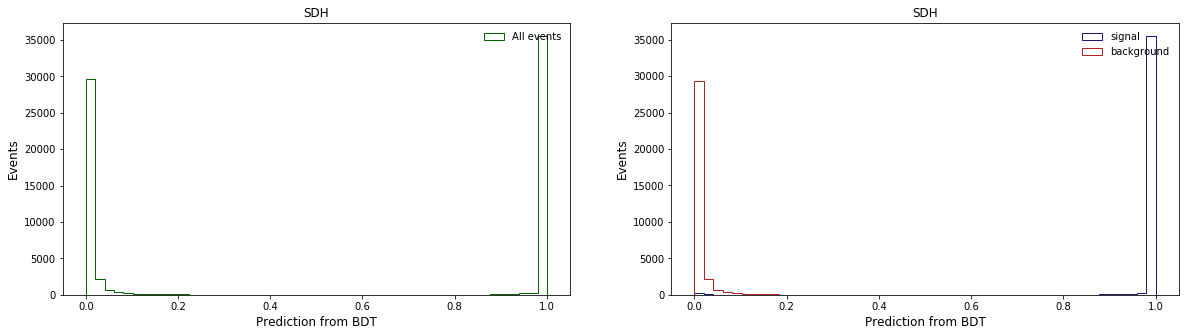

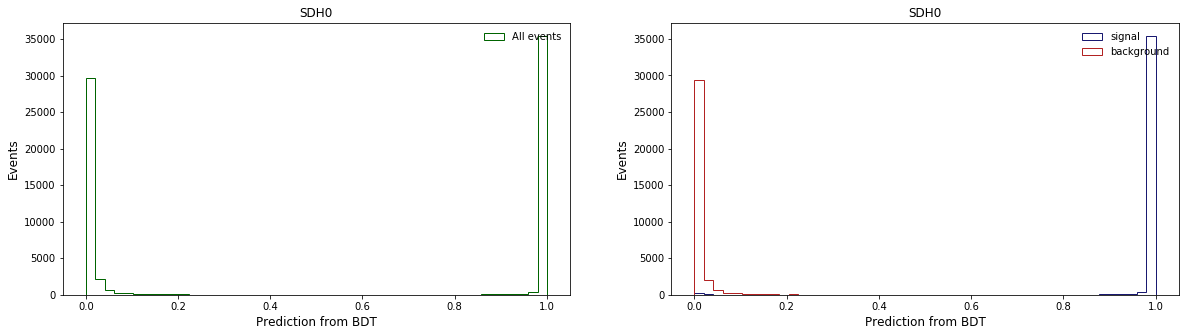

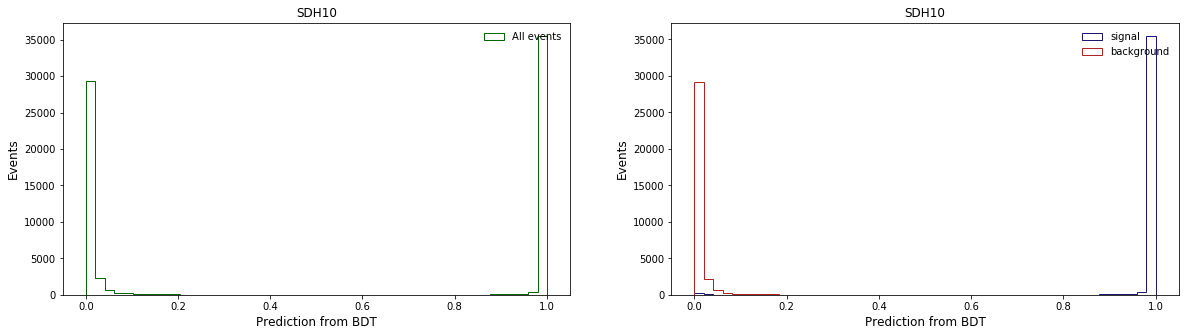

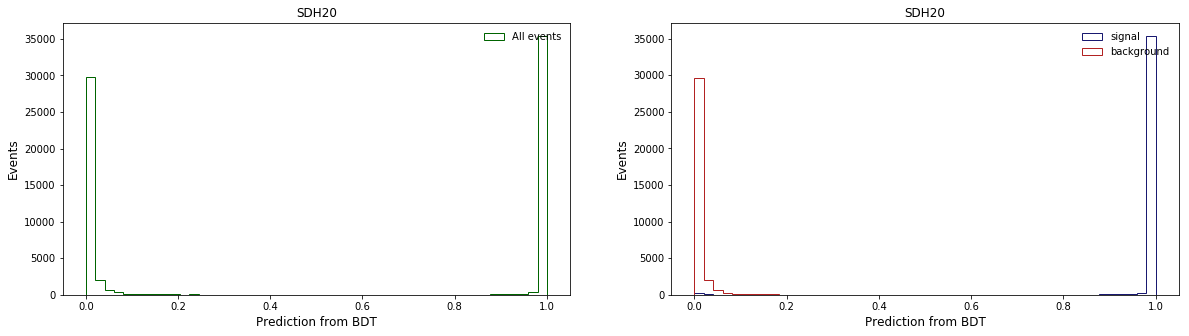

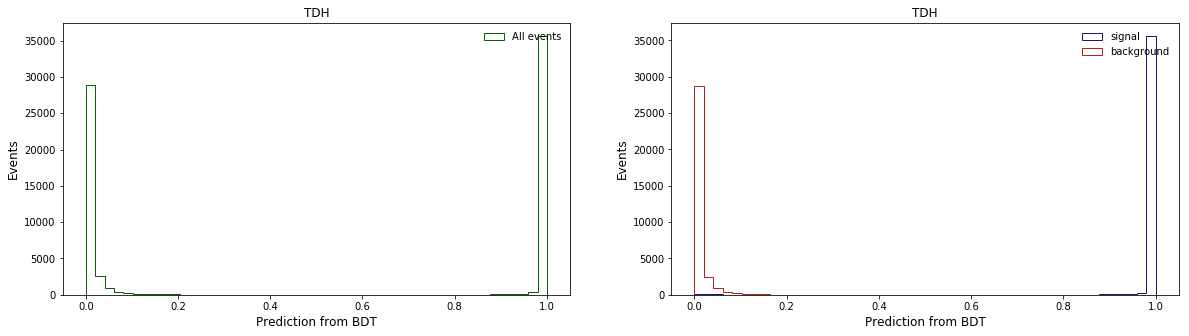

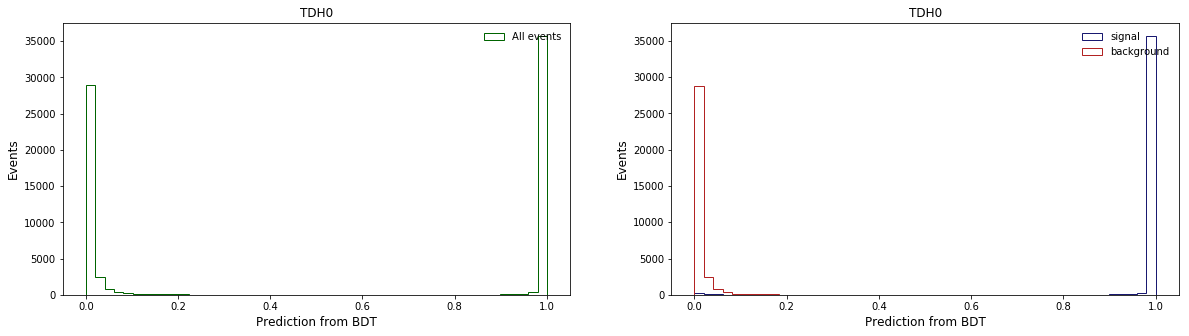

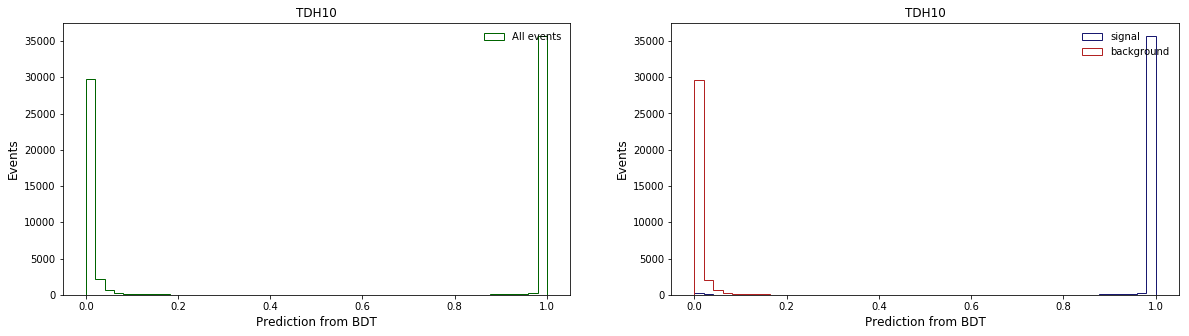

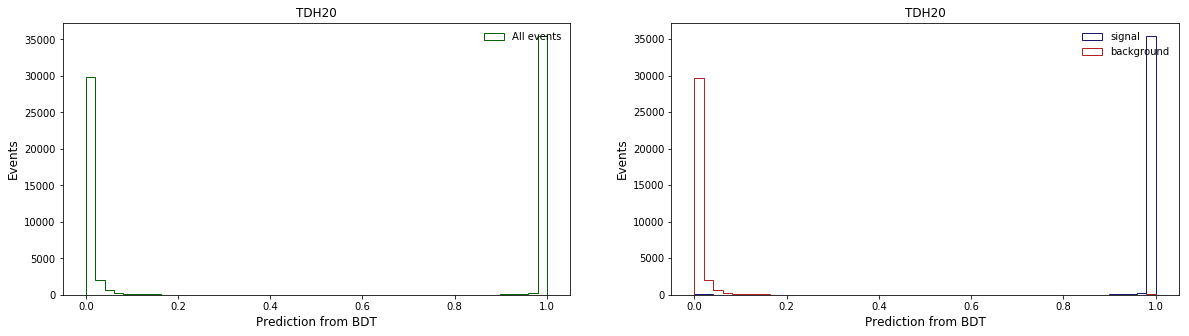

In [16]:
for i in algo:
# plot all predictions (both signal and background)
    plt.figure(figsize=(20,5));

    plt.subplot(121);
    plt.hist(predictions[i],bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
    plt.xlabel('Prediction from BDT',fontsize=12);
    plt.ylabel('Events',fontsize=12);
    plt.title(algo_name[i])
    plt.legend(frameon=False);

# plot signal and background separately
    plt.subplot(122);
    plt.hist(predictions[i][test[i].get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal');
    plt.hist(predictions[i][~(test[i].get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background');
# make the plot readable
    plt.xlabel('Prediction from BDT',fontsize=12);
    plt.ylabel('Events',fontsize=12);
    plt.title(algo_name[i])
    plt.legend(frameon=False);


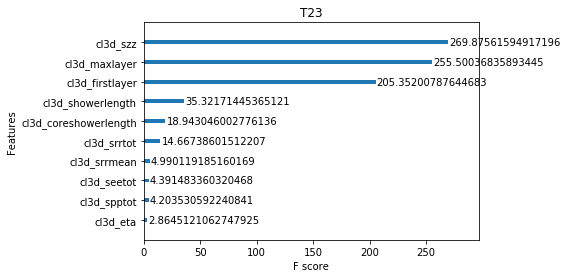

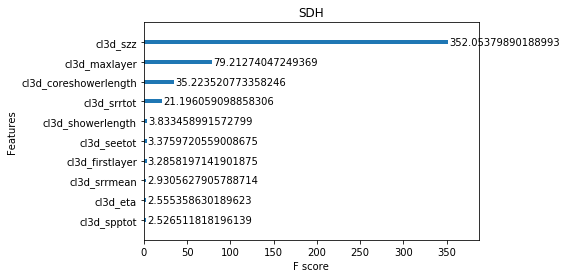

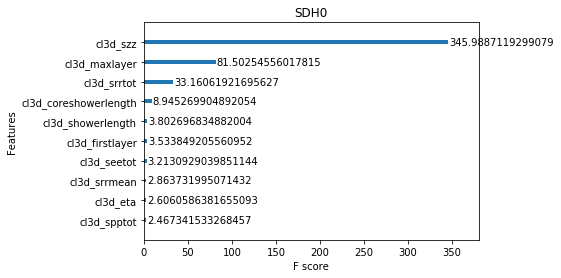

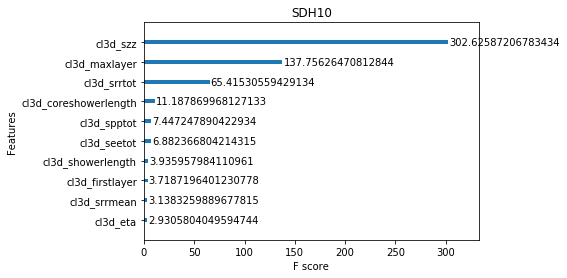

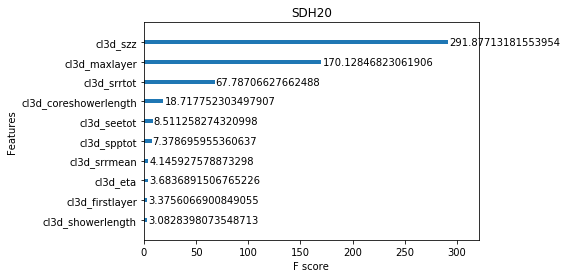

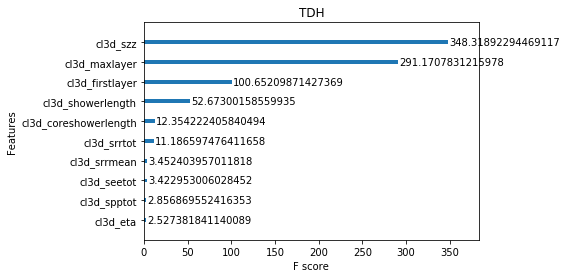

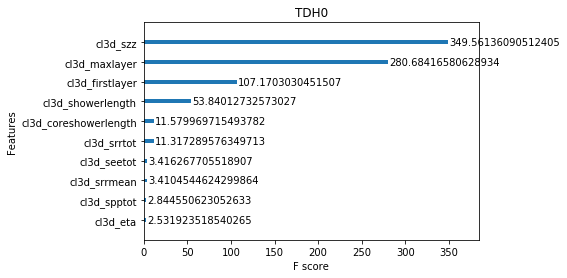

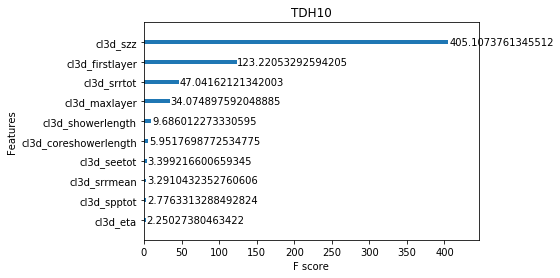

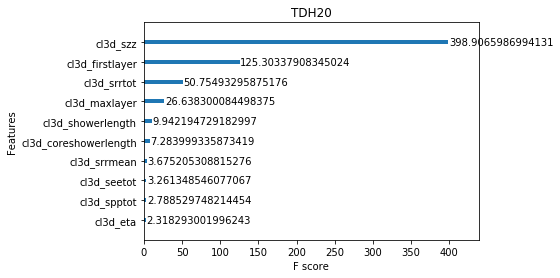

In [17]:
for i in algo:
    xgb.plot_importance(booster[i],grid=False, title=algo_name[i], importance_type='gain');

In [18]:
def plot_discr(feature):
    nbins=20
    plt.hist(X_train[i][feature][y_train[i] == 0],
         histtype='step',color='midnightblue',label='electrons', bins=nbins);
    plt.hist(X_train[i][feature][y_train[i] == 1],
         histtype='step',color='firebrick',label='pions', bins=nbins);
    plt.xlabel(feature,fontsize=12);
    plt.ylabel('Events',fontsize=12);
    plt.legend(frameon=False);

Wall time: 2.7 s


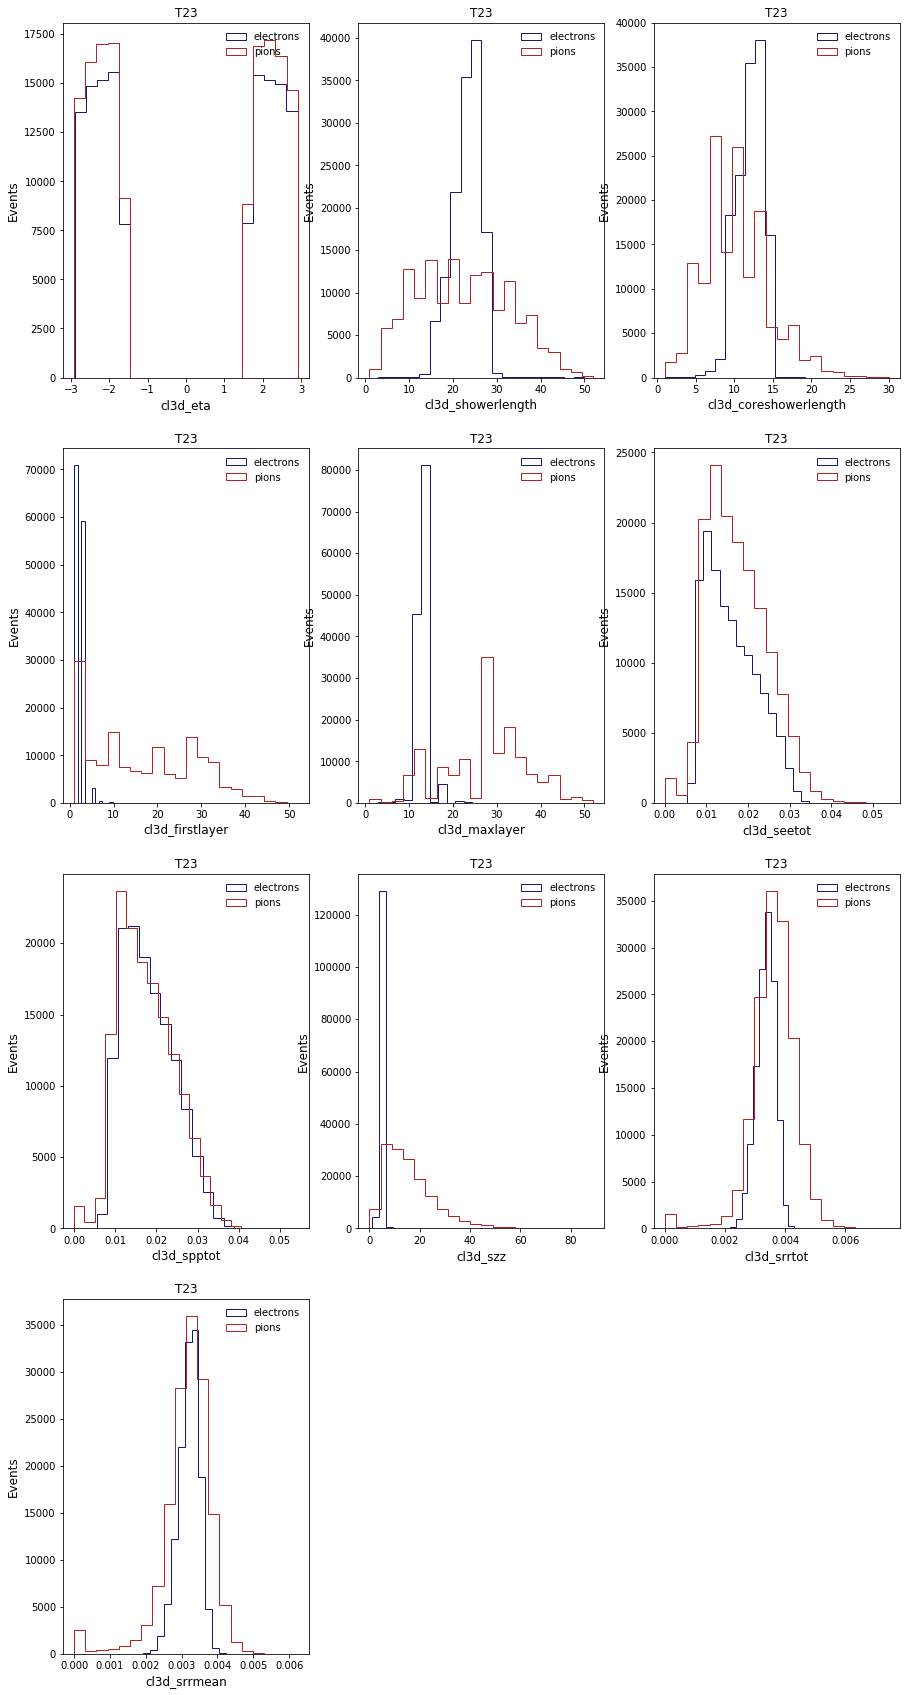

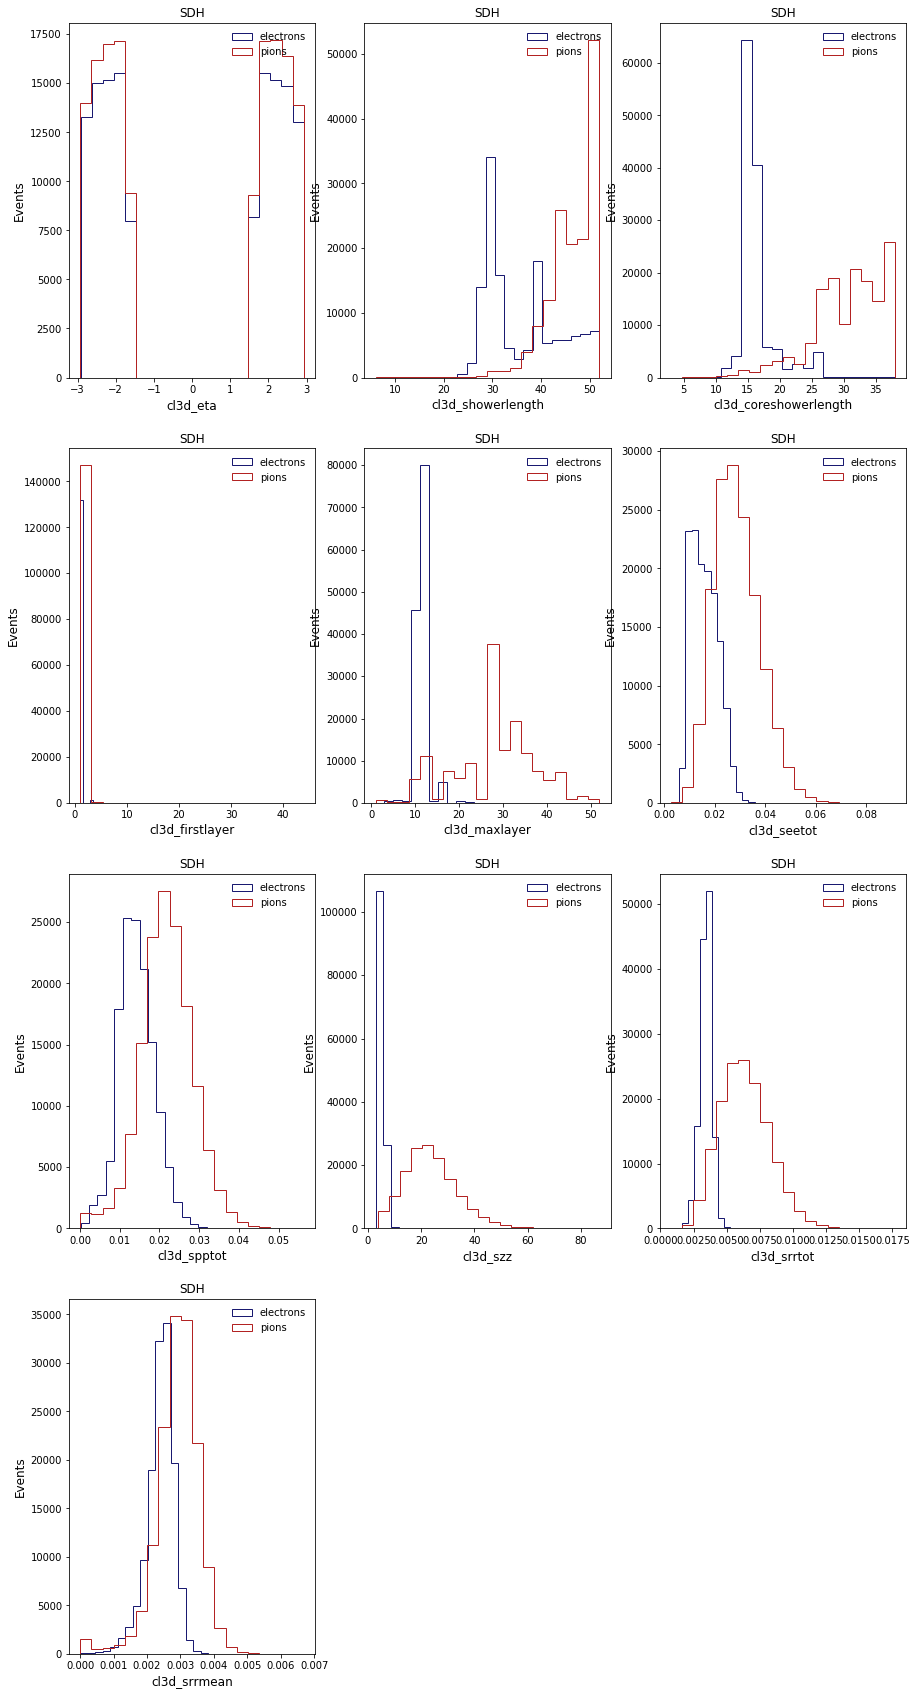

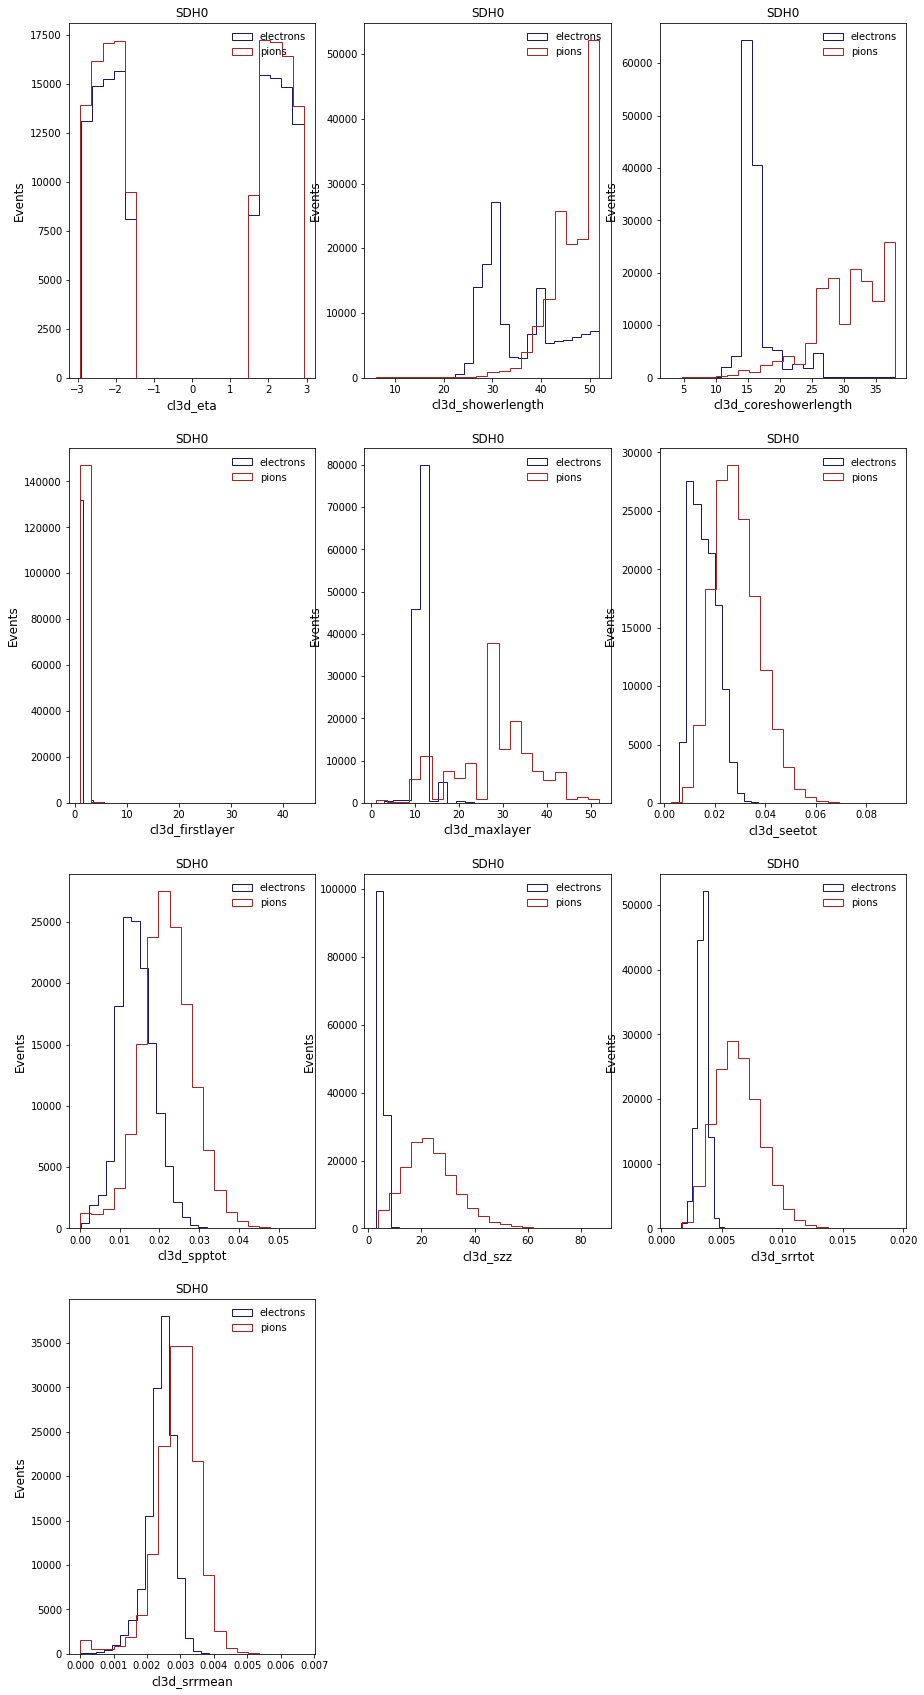

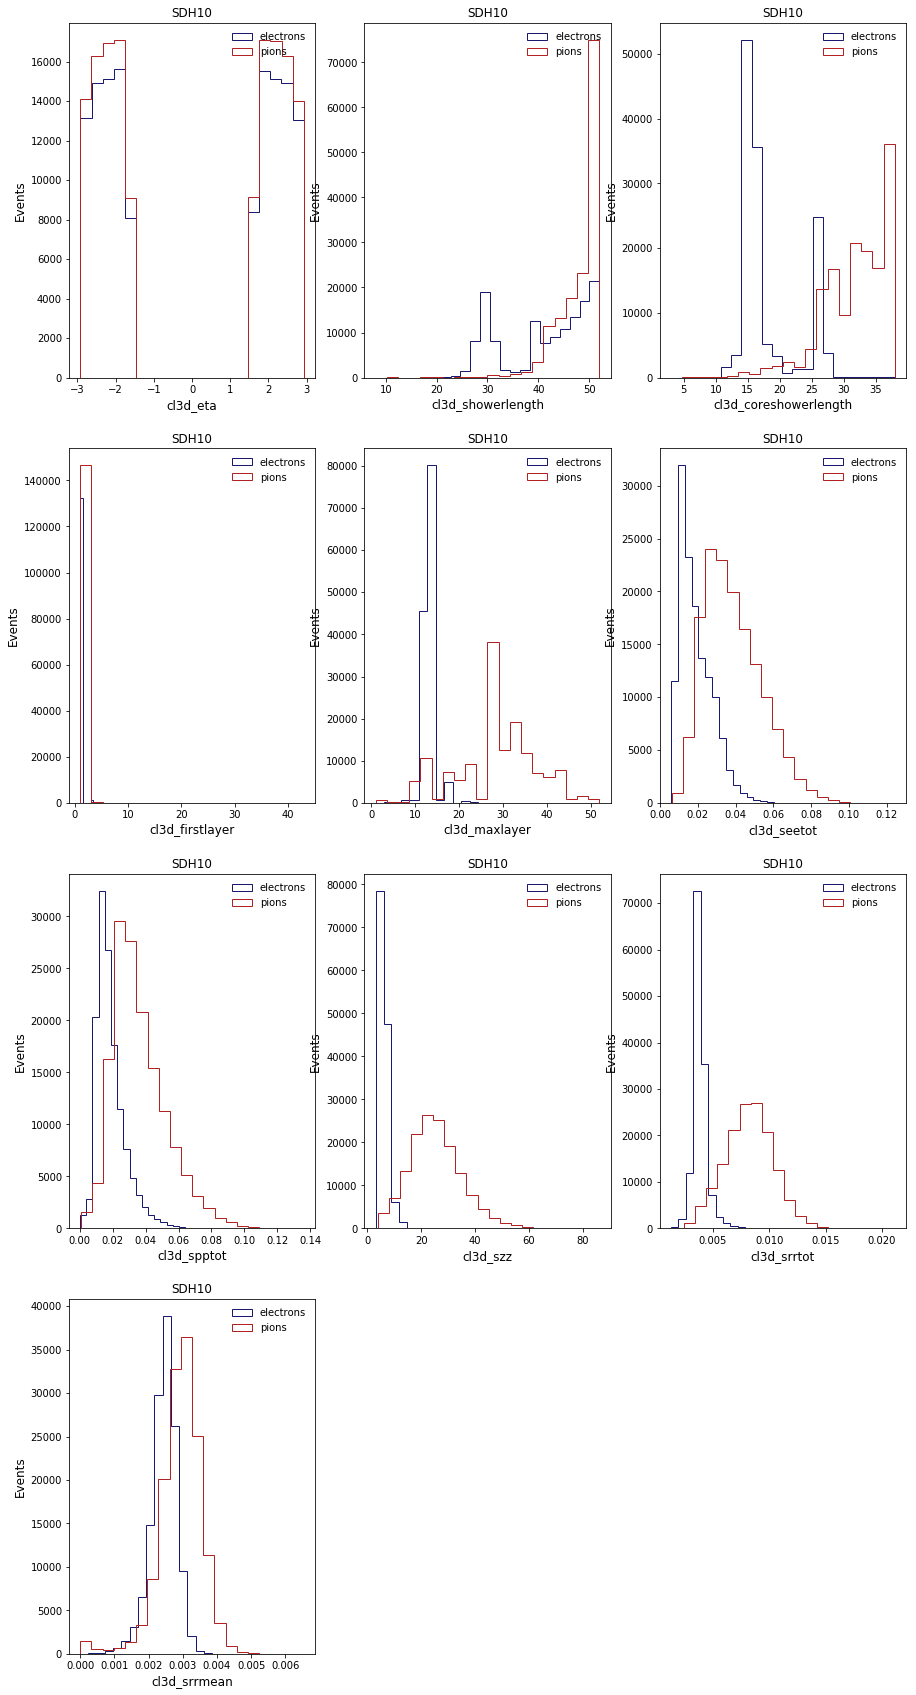

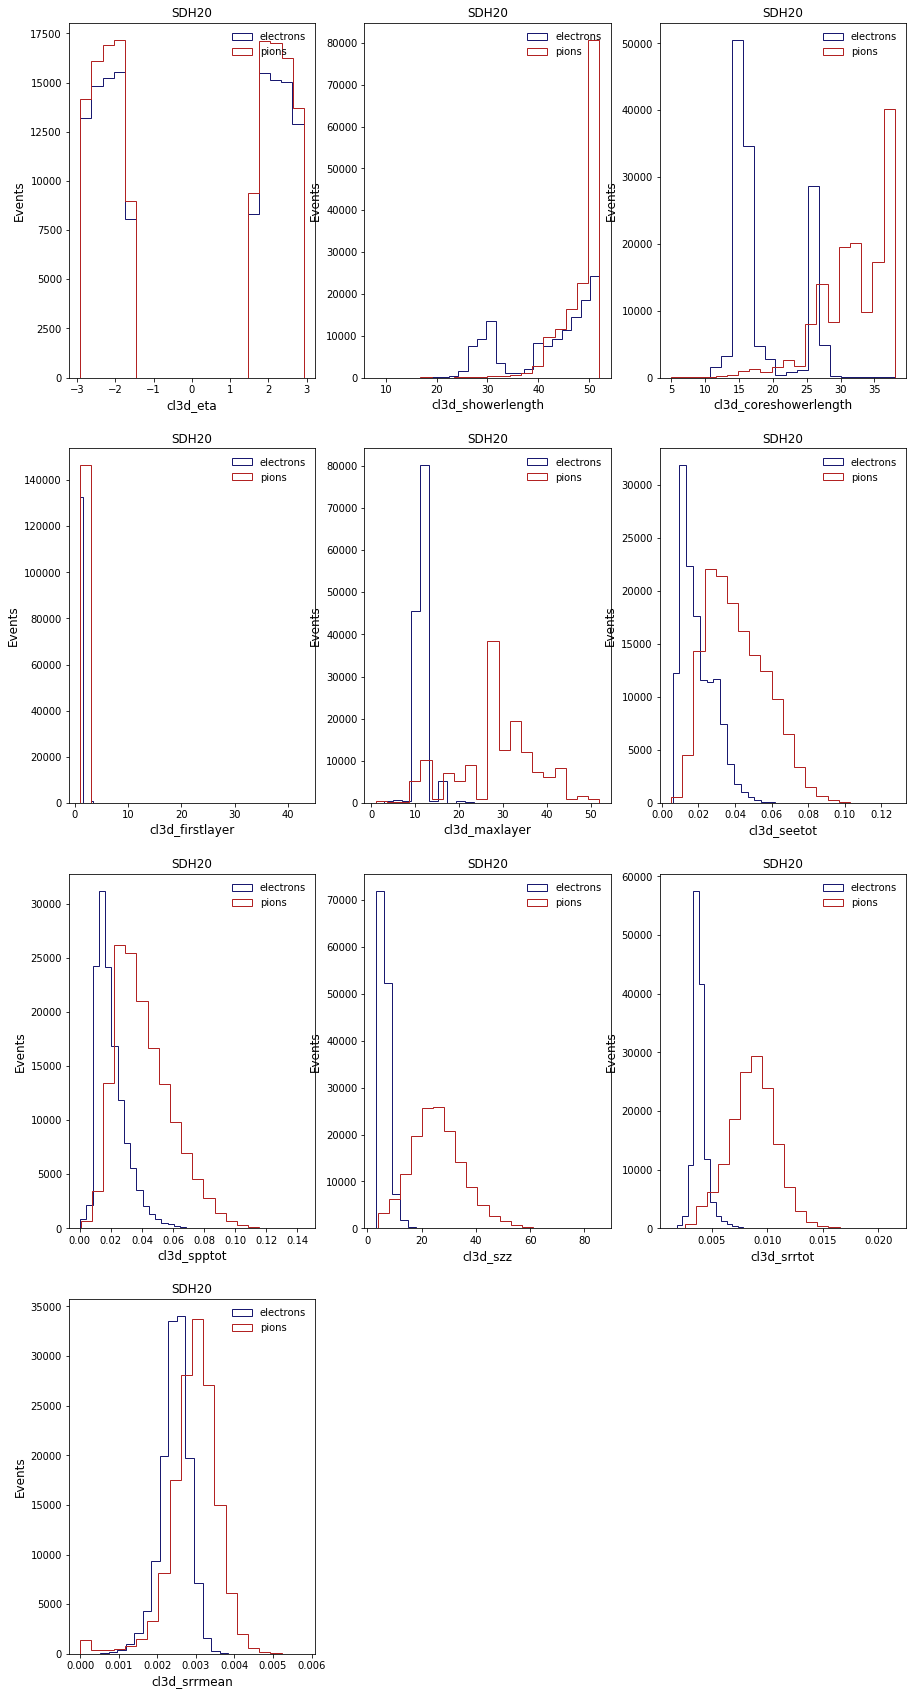

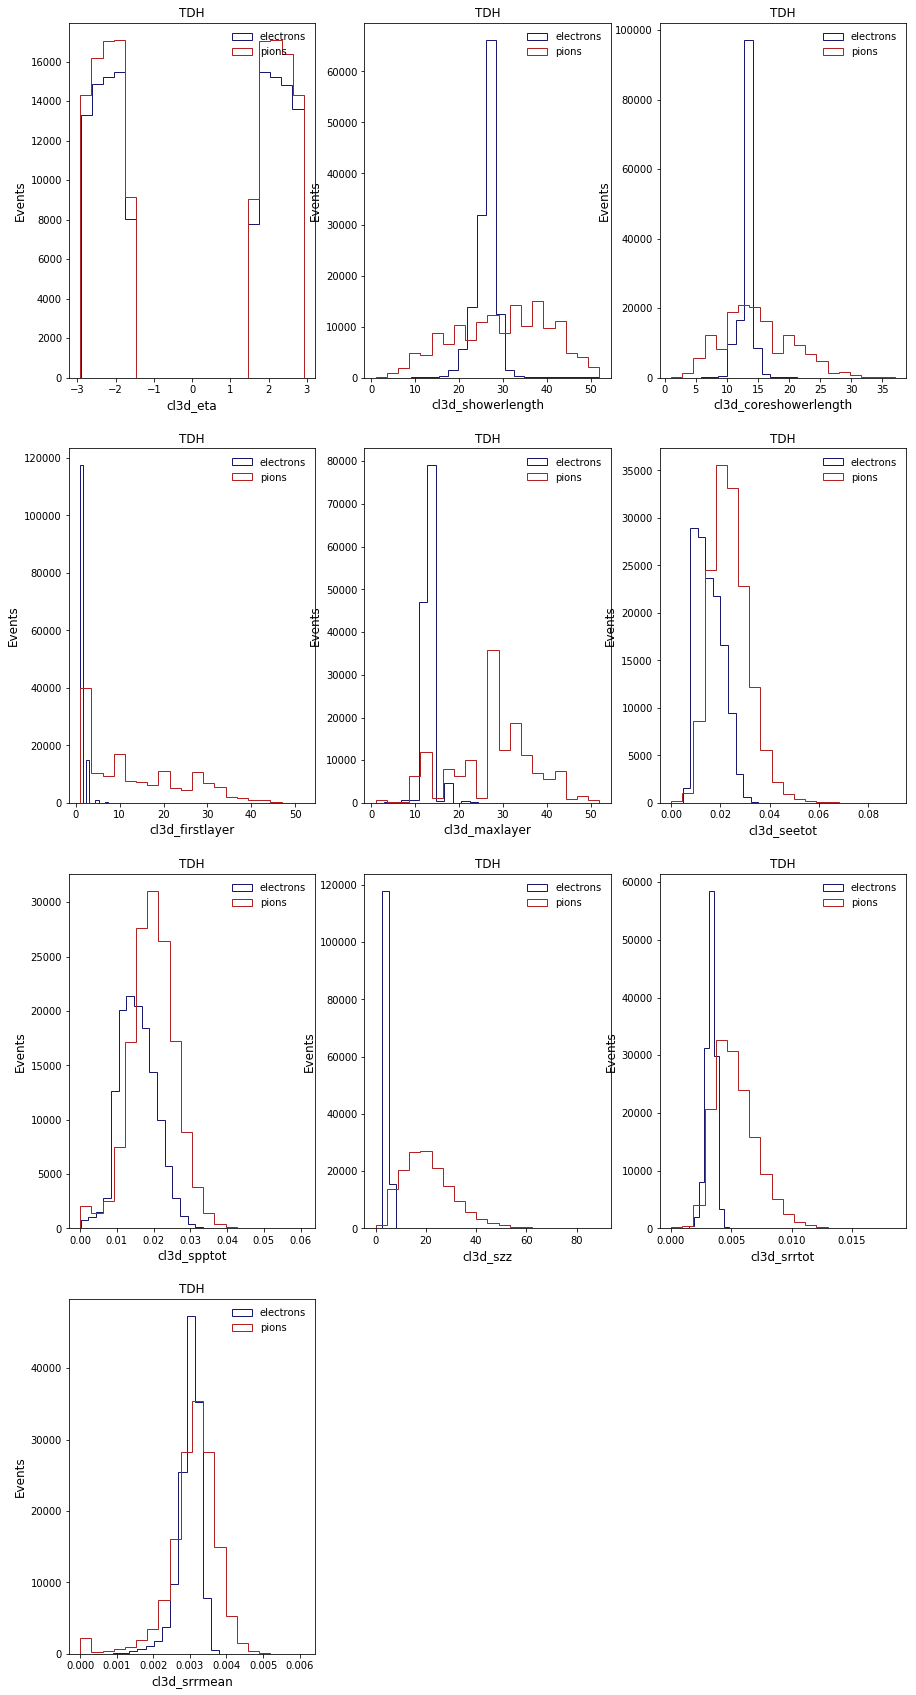

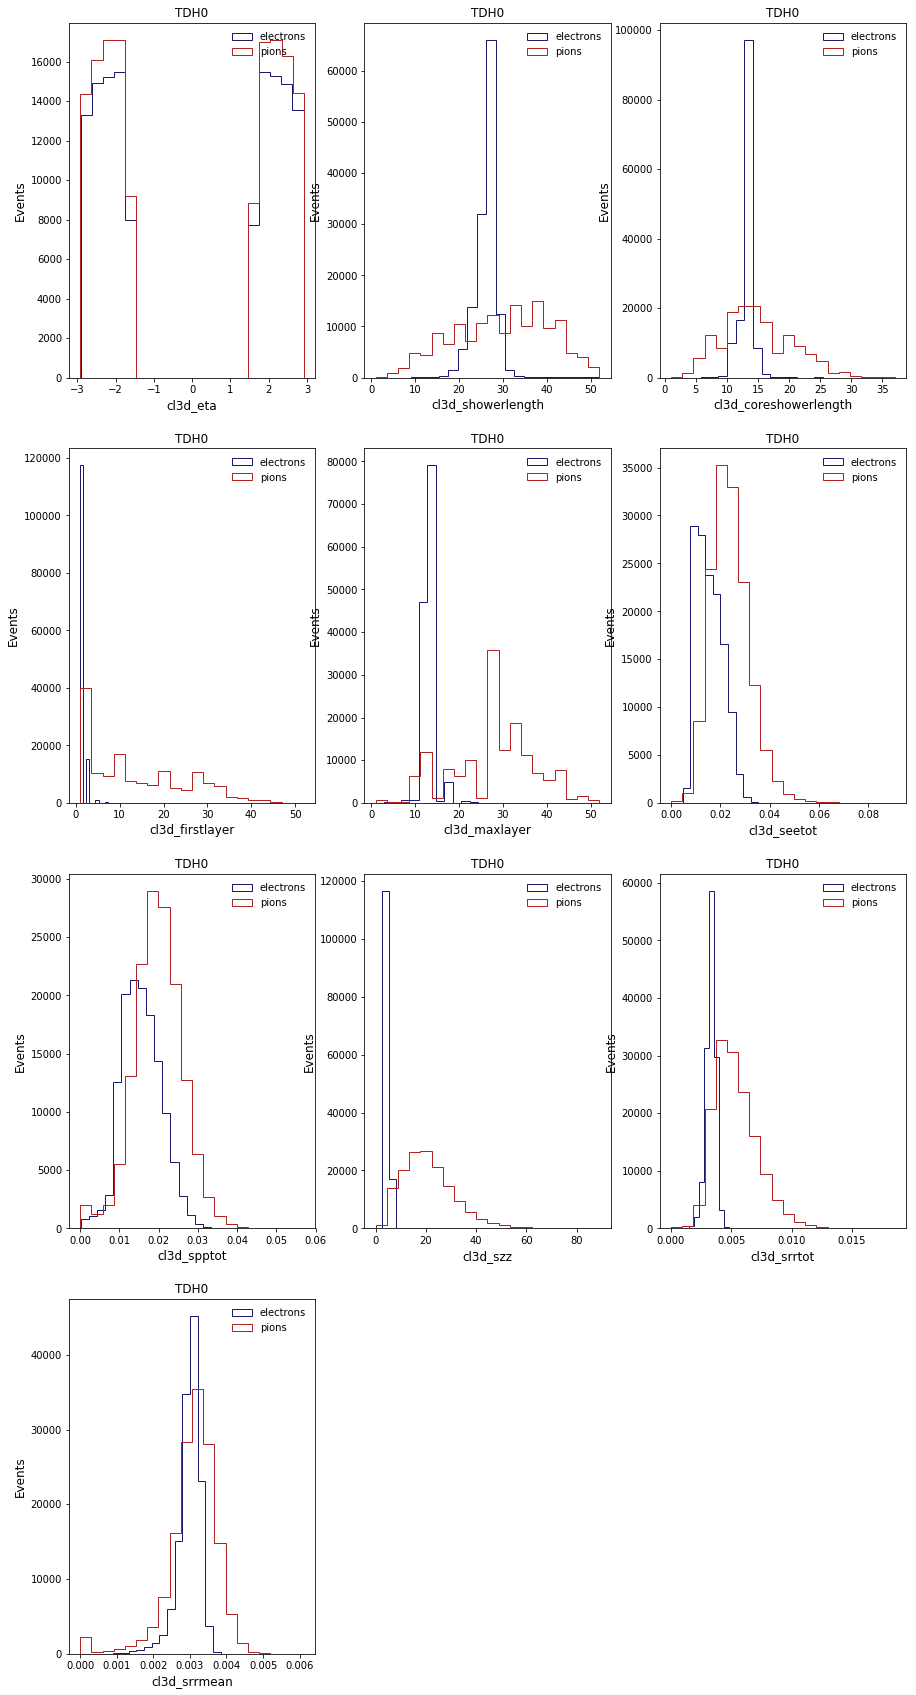

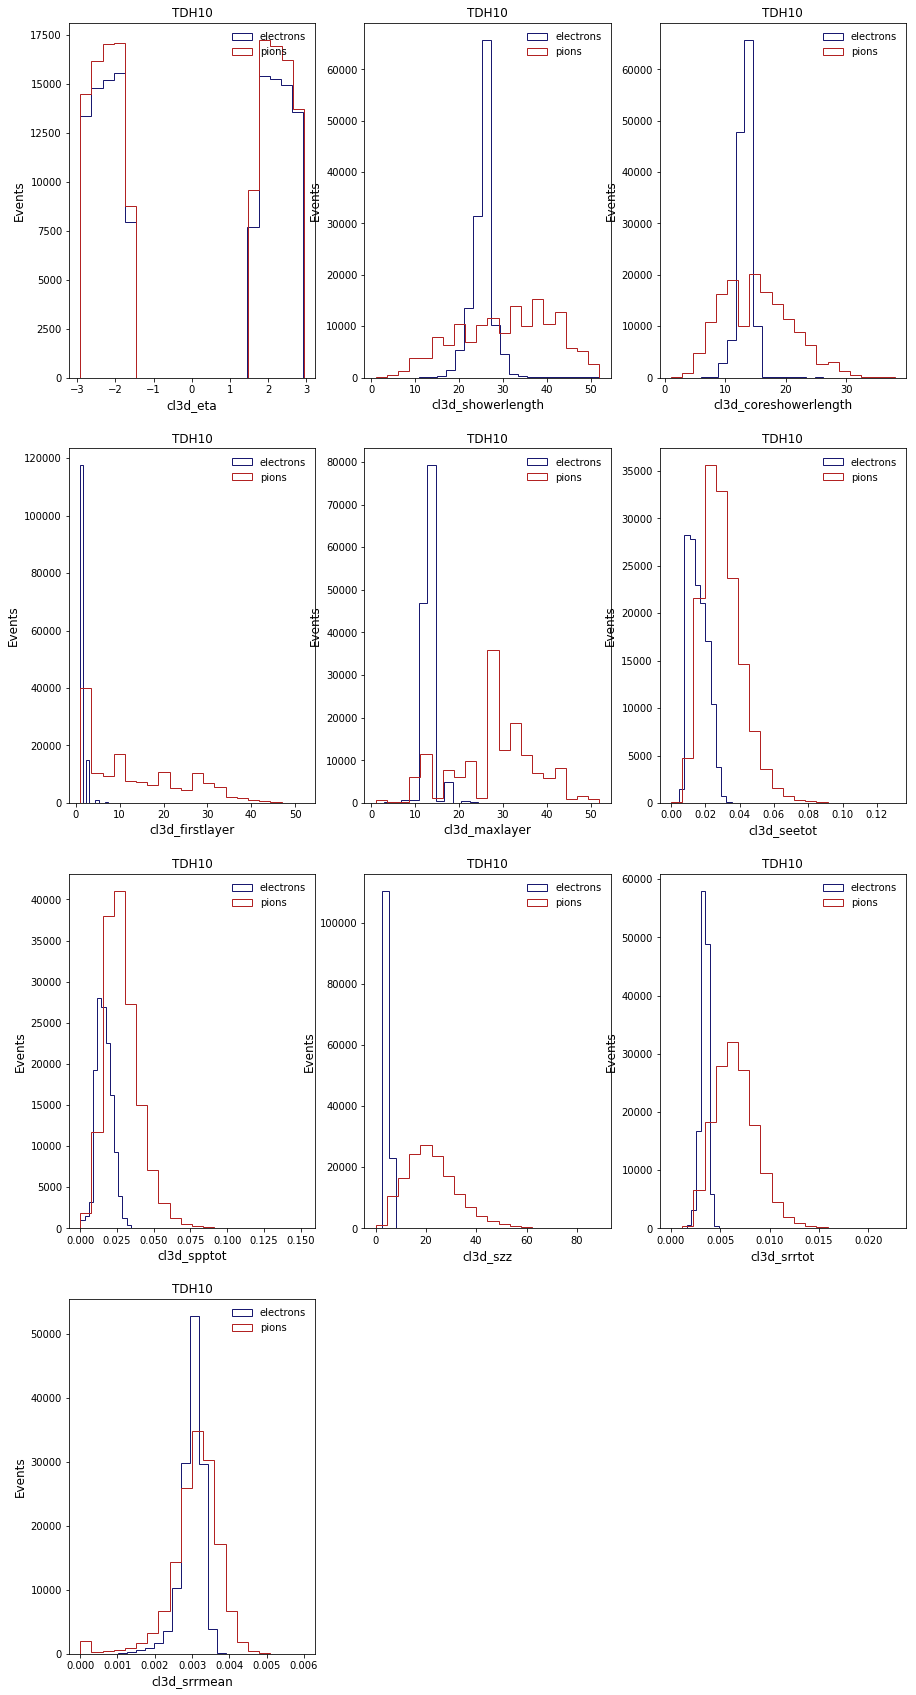

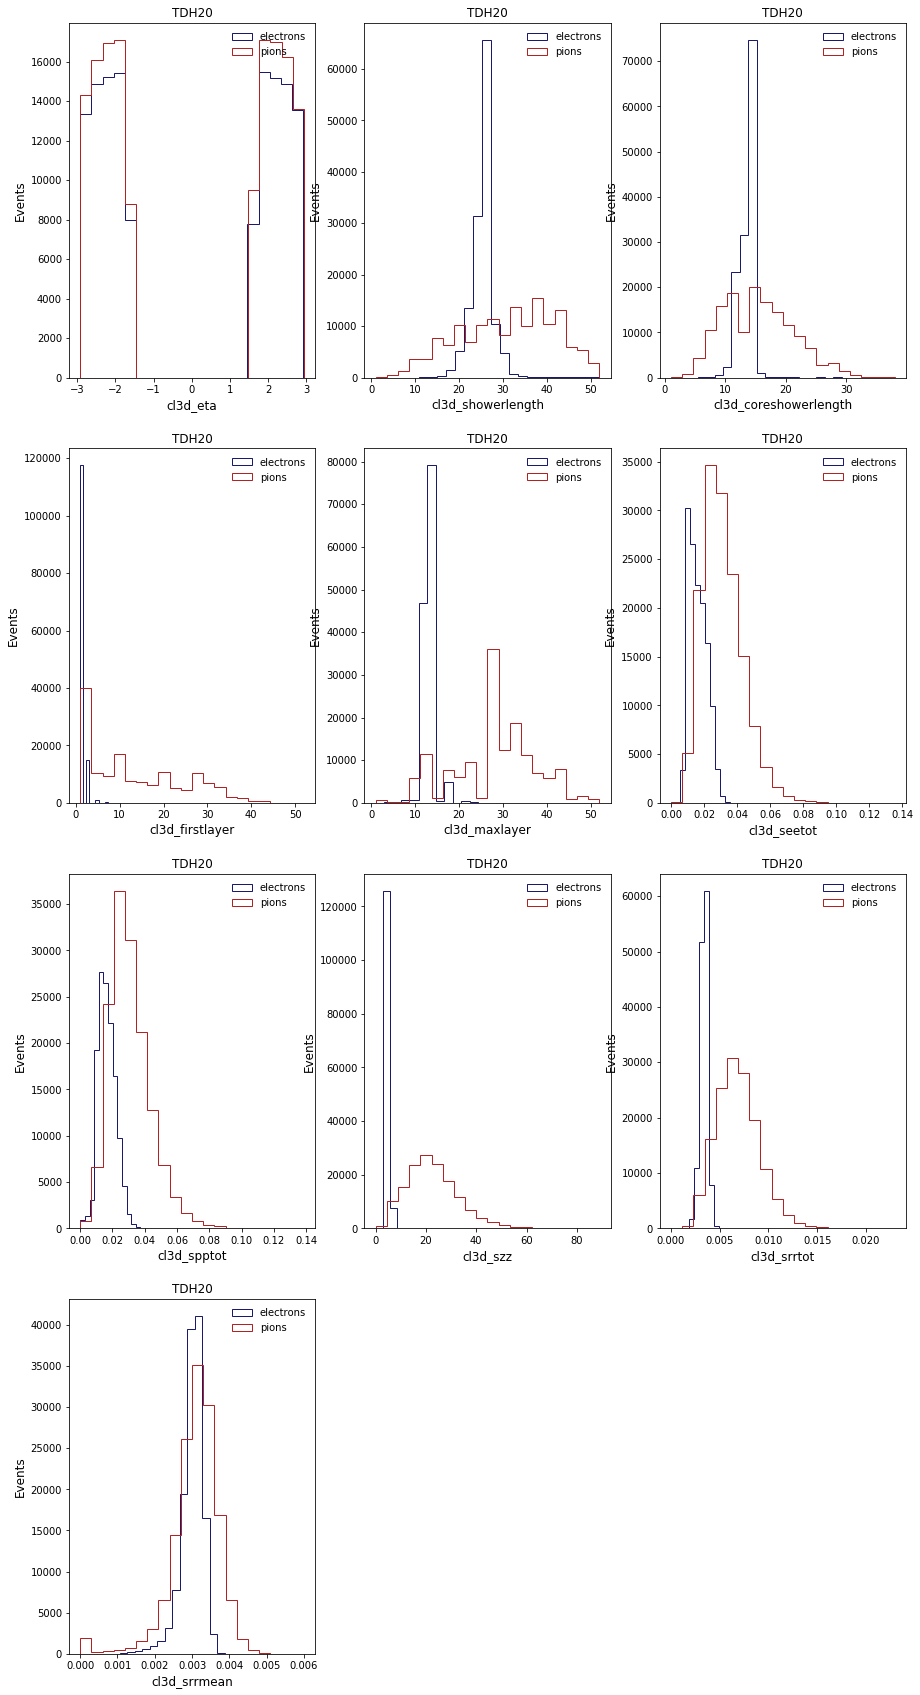

In [19]:
%%time
for i in algo:
    plt.figure(figsize=(15,30))
    j=0
    for feature in columns:
        j+=1
        plt.subplot(4,3,j)
        plot_discr(feature)
        plt.title(algo_name[i])


In [20]:
from sklearn import metrics
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title(algo_name[i])
    plt.plot(tpr,np.log(1-fpr), 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    #plt.plot([0, 1], [0, 1],'r--')
    plt.xlim(0.8,1)
    #plt.ylim(0.6,1.05)
    plt.xlabel('True Positive Rate')
    plt.ylabel('Log Rejection Rate')
    

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


Text(0,0.5,'Log Rejection Rate')

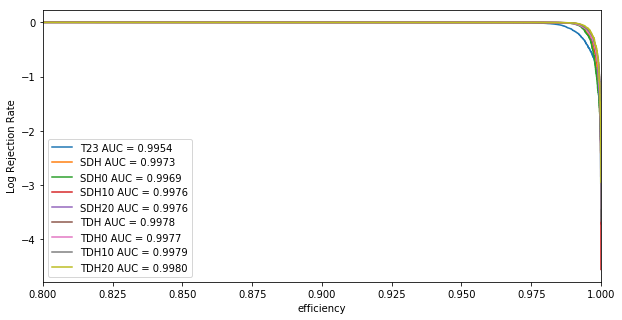

In [21]:
from sklearn import metrics
plt.figure(figsize=(10,5))
for i in algo:
    #buildROC(y_test[i], predictions[i])
    fpr, tpr, threshold = metrics.roc_curve(y_test[i],predictions[i])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(tpr,np.log(1-fpr), label ='%s AUC = %0.4f' %(algo_name[i],roc_auc))
plt.legend(loc = 'lower left')
    #plt.plot([0, 1], [0, 1],'r--')
plt.xlim(0.8,1)
    #plt.ylim(0.6,1.05)
plt.xlabel('efficiency')
plt.ylabel('Log Rejection Rate')    

In [22]:
def score(ytest, ypred, thr):
    fpr, tpr, threshold = metrics.roc_curve(ytest,ypred)
    roc=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
    roc_cut=roc[roc['tpr']>thr];
    score=np.max(1-roc_cut['fpr']);
    return score
    

In [23]:
thr=0.995
scor=[]
for i in algo:
    scor.append(score(y_test[i], predictions[i],thr))
    print('rejection rate for %s at %0.3f threshold=' %(algo_name[i],thr) ,scor[i])

rejection rate for T23 at 0.995 threshold= 0.6625661693936478
rejection rate for SDH at 0.995 threshold= 0.8376979020141861
rejection rate for SDH0 at 0.995 threshold= 0.8043426247158751
rejection rate for SDH10 at 0.995 threshold= 0.8740613924430829
rejection rate for SDH20 at 0.995 threshold= 0.8889355070726445
rejection rate for TDH at 0.995 threshold= 0.8675337908712201
rejection rate for TDH0 at 0.995 threshold= 0.8644577407618991
rejection rate for TDH10 at 0.995 threshold= 0.887505624718764
rejection rate for TDH20 at 0.995 threshold= 0.9076642007846896


Text(0,0.5,'Background rejection')

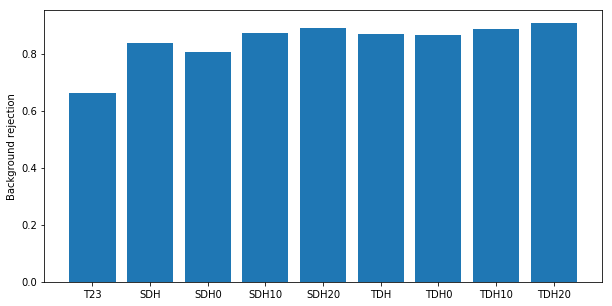

In [24]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(len(algo_name)), scor)
plt.xticks(np.arange(len(algo_name)), algo_name);
plt.ylabel('Background rejection')

Now we want to study bdt efficiency as a function of pt/eta

In [65]:
#CALCULATE ERROR BARS
conf_level=0.99
from scipy import stats
#normal
#def error(total, score, conf_level):
#    alpha=(1-conf_level)/2
#    sigma=np.sqrt(score*(1-score)/total)
#    delta=np.abs(score-stats.norm.ppf(1-alpha,loc=score, scale=sigma))
#    return delta

#clopper pearson
def error(total, score, conf_level):
    alpha=(1-conf_level)/2
    n=total
    k=score*n
    lo = score-stats.beta.ppf(alpha/2, k, n-k+1)
    hi = stats.beta.ppf(1 - alpha/2, k+1, n-k)-score
    return lo, hi

In [31]:
#TODO: compare with results from BDT trained on old algo


old bdt score: 0.9735502282422059


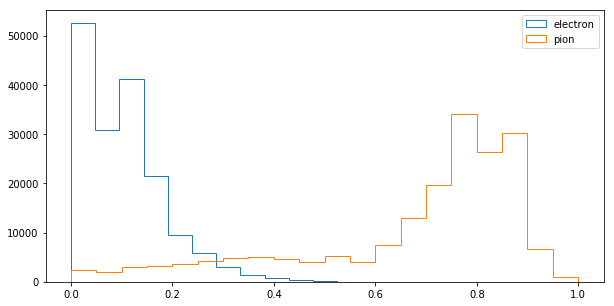

In [32]:

thr=0.9
#make the comparison
b=algo_cut[0].dropna()
a=b['cl3d_bdteg']
c=np.interp(a, (a.min(), a.max()), (1, 0))

score_old=score(b['genpart_pid'],c,thr)
print('old bdt score:', score_old)

i=0
nbins=20
plt.figure(figsize=(10,5))
plt.hist(c[b['genpart_pid']==0],histtype='step', bins=nbins, label='electron');
plt.hist(c[b['genpart_pid']==1],histtype='step',  bins=nbins, label='pion');
plt.legend()


C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Text(0,0.5,'Log Rejection Rate')

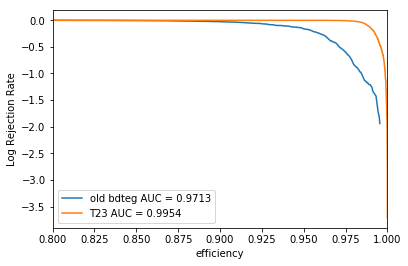

In [33]:
i=0

fpr, tpr, threshold = metrics.roc_curve(b['genpart_pid'],c)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(tpr,np.log(1-fpr), label ='old bdteg AUC = %0.4f' %(roc_auc))

fpr, tpr, threshold = metrics.roc_curve(y_test[i],predictions[i])
roc_auc = metrics.auc(fpr, tpr)
plt.plot(tpr,np.log(1-fpr), label ='%s AUC = %0.4f' %(algo_name[i],roc_auc))
    
plt.legend(loc = 'lower left')
    #plt.plot([0, 1], [0, 1],'r--')
plt.xlim(0.8,1)
    #plt.ylim(0.6,1.05)
plt.xlabel('efficiency')
plt.ylabel('Log Rejection Rate')  

C:\ProgramData\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Wall time: 4.55 s


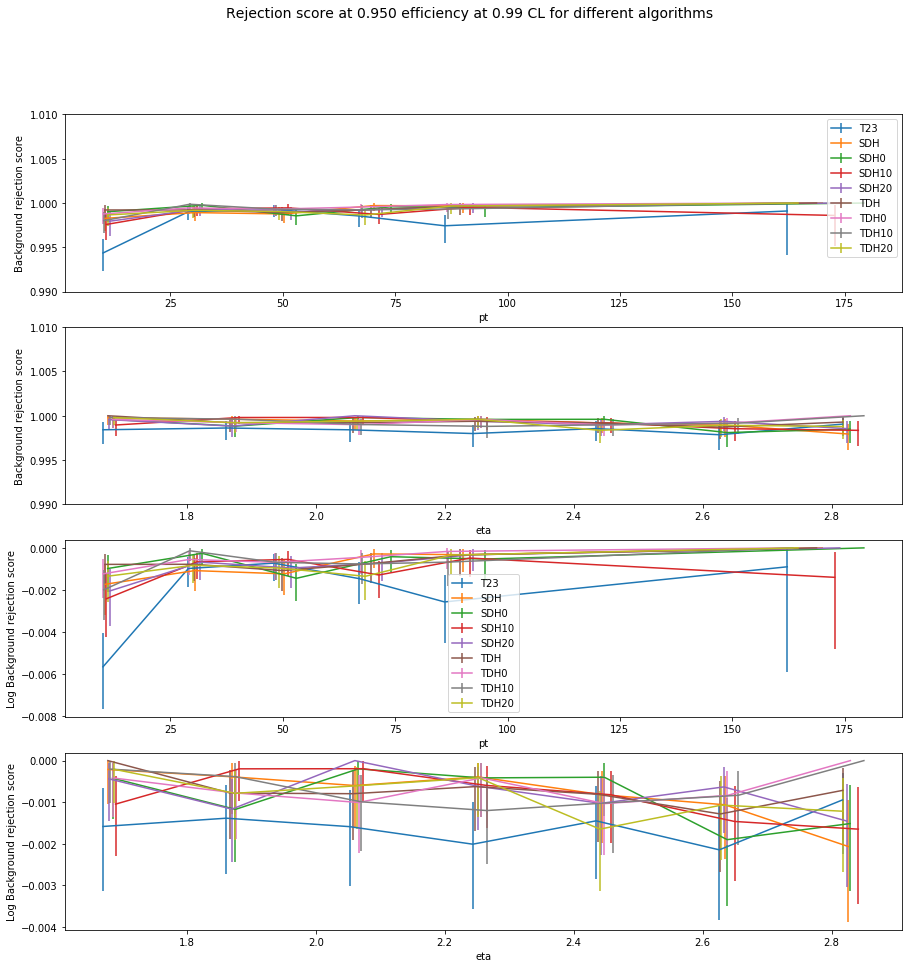

In [80]:
%%time
fig=plt.figure(figsize=(15,15))
thr=0.95
nbins=7
conf_level=0.99
pred_pt={}
y_test_pt={}
bins_pt={}
score_pt={}
y_err_pt={}
#faire les bins après entrainement du bdt
#--> predictions[i] vs y_test[i]
#predictions[i]=booster[i].predict(test[i])--> binner test[i]
# --> binner X_test[i] et y_test[i]
for i in algo:
    
    pt_max=np.max(X_pt[i])
    pt_min=np.min(X_pt[i])
    range_pt=pt_max-pt_min
    bins_pt=[]
    score_pt=[]
    y_err_pt=[]
    y_err_pt_lo=[]
    y_err_pt_hi=[]
    pred_pt={}
    y_test_pt={}
    
    
    X_test[i]['abseta']=np.abs(X_test[i]['cl3d_eta'])
    eta_max=np.max(X_test[i]['abseta'])
    eta_min=np.min(X_test[i]['abseta'])
    range_eta=eta_max-eta_min
    bins_eta=[]
    score_eta=[]
    y_err_eta=[]
    y_err_eta_lo=[]
    y_err_eta_hi=[]
    pred_eta={}
    y_test_eta={}
    for j in range(nbins):
       
        #make sure last bins are not too small
        n_min=X_pt[i].shape[0]/(1.4*nbins)
        
        sel=(X_pt[i] >= (pt_min+j*range_pt/nbins)) & (X_pt[i] < (pt_min+(j+1)*range_pt/nbins))
        
        if X_pt[i][sel].shape[0]>n_min:
            bins_pt.append(((pt_min+j*range_pt/nbins)+(pt_min+(j+1)*range_pt/nbins))/2)
           
            pred_pt[j]=predictions[i][sel]
            
            y_test_pt[j]=y_test[i][sel]
        else: 
            bins_pt.append(((pt_min+j*range_pt/nbins)+(pt_max)/2))
            sel=(X_pt[i] >= (pt_min+j*range_pt/nbins))
            pred_pt[j]=predictions[i][sel]
            y_test_pt[j]=y_test[i][sel]
            
            break       

    for j in range(len(pred_pt)): 
        
        score_pt.append(score(y_test_pt[j], pred_pt[j],thr))
        #print('rejection rate for pt bin %d at %0.3f threshold=' %(j+1,thr),  score_pt[j])
        
        lo,hi=error(y_test_pt[j].shape[0], score(y_test_pt[j], pred_pt[j], thr), conf_level)
        
        y_err_pt_lo.append(lo)
        y_err_pt_hi.append(hi)
        
    
    for j in range(nbins):
        
        bins_eta.append(((eta_min+j*range_eta/nbins)+(eta_min+(j+1)*range_eta/nbins))/2)
        sel=(X_test[i]['abseta'] > (eta_min+j*range_eta/nbins)) & (X_test[i]['abseta'] < (eta_min+(j+1)*range_eta/nbins))
        
        pred_eta[j]=predictions[i][sel]
        
        y_test_eta[j]=y_test[i][sel]
        score_eta.append(score(y_test_eta[j], pred_eta[j],thr))
        lo, hi=error(y_test_eta[j].shape[0], score(y_test_eta[j], pred_eta[j], thr), conf_level)
        y_err_eta_lo.append(lo)
        y_err_eta_hi.append(hi)
        
        
        
    y_err_pt=[y_err_pt_lo, y_err_pt_hi]
    y_err_eta=[y_err_eta_lo, y_err_eta_hi]
        
    plt.subplot(411);
    plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i]);
    plt.ylabel('Background rejection score');
    plt.xlabel('pt');
    plt.ylim(0.99,1.01)
    plt.legend()
    
    plt.subplot(412);
    plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i]);
    plt.ylabel('Background rejection score');
    plt.xlabel('eta');
    plt.ylim(0.99,1.01)
    plt.legend()
    
    plt.subplot(413);
    plt.errorbar(bins_pt, np.log(score_pt), y_err_pt, label=algo_name[i]);
    plt.ylabel('Log Background rejection score');
    plt.xlabel('pt');
    #plt.ylim(0.99,1.01)
    plt.legend()
    
    plt.subplot(414);
    plt.errorbar(bins_eta, np.log(score_eta), y_err_eta, label=algo_name[i]);
    plt.ylabel('Log Background rejection score');
    plt.xlabel('eta');
    #plt.ylim(0.99,1.01)
    plt.legend()
    
    plt.suptitle('Rejection score at %0.3f efficiency at %0.2f CL for different algorithms' %(thr, conf_level), fontsize=14)
    plt.savefig('Algo_comparison.png')

todo: same in eta

In [49]:
asymmetric_error

[array([0.048, 0.088, 0.128, 0.168, 0.208, 0.248, 0.288, 0.328]),
 array([0.12, 0.22, 0.32, 0.42, 0.52, 0.62, 0.72, 0.82])]